# PyGRASS

PyGRASS脚本库，最初是在Google Summer of Code 2012期间开发的，[PyGRASS](http://grass.osgeo.org/grass70/manuals/libpython/pygrass_index.html)主要有以下两个功能：

* 提供了Python接口，通过GRASS的[C API](http://grass.osgeo.org/programming7/)的ctypes绑定，可以读取和写入本地GRASS GIS 7数据结构
* 使用对象检查参数并执行相应的GRASS GIS模块

有关实现思想和性能的进一步讨论，请参见本文：
[Zambelli, P.; Gebbert, S.; Ciolli, M.	 Pygrass: An Object Oriented Python Application Programming Interface (API) for Geographic Resources Analysis Support System (GRASS) Geographic Information System (GIS). *ISPRS Int. J. Geo-Inf.* 2013, 2, 201-219.](http://www.mdpi.com/2220-9964/2/1/201)

## 通过Python调用GRASS GIS的C API


在Python中使用GRASS模块进行标准脚本编写有时可能会让人望而却步，特别是在执行概念上简单的事情时，例如：遍历矢量要素或栅格行/列。如果使用标准脚本方法，需要以下几个步骤：

- 创建临时文件
- 读取和转换临时文件
- 导入数据
- 移除处理过程中产生的不必要的文件


GRASS GIS大部分是用C语言编写的[C API](http://grass.osgeo.org/programming7/)。在Python中，PyGRASS库引入了几个对象，这些对象允许使用GRASS GIS的基础C API直接与数据进行交互。


到目前为止，涵盖了三种处理过程：

- 矢量地图
- 栅格地图
- 地图集和计算区域


### 对矢量数据的操作

#### 创建一个新的矢量图层

导入必要的类库：

In [1]:
from grass.pygrass.vector import VectorTopo
from grass.pygrass.vector.geometry import Point

创建矢量图层实例：

In [2]:
view_points = VectorTopo('view_points')

以写入模式打开矢量图层：

In [3]:
view_points.open(mode='w')

创建一些几何向量，例如创建两个点geometry：

In [4]:
point1 = Point(635818.8, 221342.4)
point2 = Point(633627.7, 227050.2)

然后将这两个点写入到创建的矢量图层中：

In [5]:
view_points.write(point1)
view_points.write(point2)

最后，关闭矢量图层实例：

In [6]:
view_points.close()

现在，可以利用[context manager syntax](https://www.python.org/dev/peps/pep-0343/)提供的`with`函数，自动重复操作，并创建和设置属性表：

In [8]:
# 定义矢量图层的属性列
cols = [(u'cat',       'INTEGER PRIMARY KEY'),
        (u'name',      'TEXT')]

with VectorTopo('view_points', mode='w', tab_cols=cols, overwrite=True) as view_points:
    # 保存点位置信息和属性
    view_points.write(point1, ('pub', ))
    view_points.write(point2, ('restaurant', ))
    # 保存更改到数据中
    view_points.table.conn.commit()

注意：我们不需要关闭矢量图层，因为上下文管理器context manager syntax已经自动将其关闭。

#### 读取已有的矢量图层

In [9]:
with VectorTopo('view_points', mode='r') as points:
    for point in points:
        print(point, point.attrs['name'])

(Point(635818.800000, 221342.400000), u'pub')
(Point(633627.700000, 227050.200000), u'restaurant')


### 对栅格数据的操作

同样，栅格地图的操作函数类可以被导入：


In [10]:
from grass.pygrass.raster import RasterRow

#### 读取已有的栅格图层

实例化栅格：

In [11]:
elev = RasterRow('elevation', mapset='PERMANENT')

跟矢量数据操作相同，打开栅格数据：

In [13]:
elev.open(mode='r')

现在，我们可以逐行读取整个栅格地图，下面我们显示读取第一行的示例：

In [14]:
row = elev[0]

In [15]:
row

Buffer([141.99614 , 141.27849 , 141.37904 , ...,  58.408253,  58.307114,
         58.183105], dtype=float32)

由于行实例是从numpy数组继承的，因此您可以将它们视为numpy数组：

In [16]:
row * 2

Buffer([283.99228 , 282.55698 , 282.7581  , ..., 116.816505, 116.61423 ,
        116.36621 ], dtype=float32)

In [17]:
row.shape

(1500,)

要将整个栅格地图转换为numpy数组，然后再转换回GRASS GIS栅格地图，我们可以定义两个函数，例如：

In [18]:
import numpy as np

from grass.pygrass.raster.buffer import Buffer
from grass.pygrass.gis.region import Region

def raster2numpy(rastname, mapset=''):
    """Return a numpy array from a raster map"""
    with RasterRow(rastname, mapset=mapset, mode='r') as rast:
        return np.array(rast)


def numpy2raster(array, mtype, rastname, overwrite=False):
    """Save a numpy array to a raster map"""
    reg = Region()
    if (reg.rows, reg.cols) != array.shape:
        msg = "Region and array are different: %r != %r"
        raise TypeError(msg % ((reg.rows, reg.cols), array.shape))
    with RasterRow(rastname, mode='w', mtype=mtype, overwrite=overwrite) as new:
        newrow = Buffer((array.shape[1],), mtype=mtype)
        for row in array:
            newrow[:] = row[:]
            new.put_row(newrow)

In [19]:
elev = raster2numpy('elevation', mapset='PERMANENT')

In [20]:
elev

array([[141.99614 , 141.27849 , 141.37904 , ...,  58.408253,  58.307114,
         58.183105],
       [142.90462 , 142.3945  , 142.68611 , ...,  58.314632,  58.350697,
         58.407295],
       [143.81854 , 143.54707 , 143.83972 , ...,  58.295143,  58.430656,
         58.563217],
       ...,
       [126.25296 , 126.99411 , 127.56253 , ...,  84.38535 ,  84.940025,
         85.55894 ],
       [126.55118 , 127.38738 , 127.988945, ...,  84.07343 ,  84.625854,
         85.27059 ],
       [126.69503 , 127.49923 , 128.18896 , ...,  84.0505  ,  84.85337 ,
         85.55479 ]], dtype=float32)

In [25]:
numpy2raster(elev * 2, mtype='FCELL', rastname='doubled_elev', overwrite=True)# 高程*2

In [22]:
# 导入渲染结果的函数
from render import view

from grass.pygrass.modules.shortcuts import raster as r

# 将输入和输出贴图的颜色设置为预定义的高程颜色表
r.colors(map='elevation@PERMANENT,doubled_elev', color='elevation')

Module('r.colors')

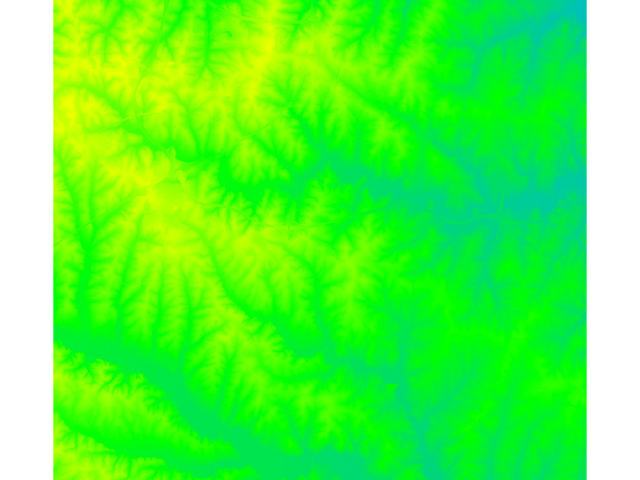

In [23]:
view(['elevation@PERMANENT'])

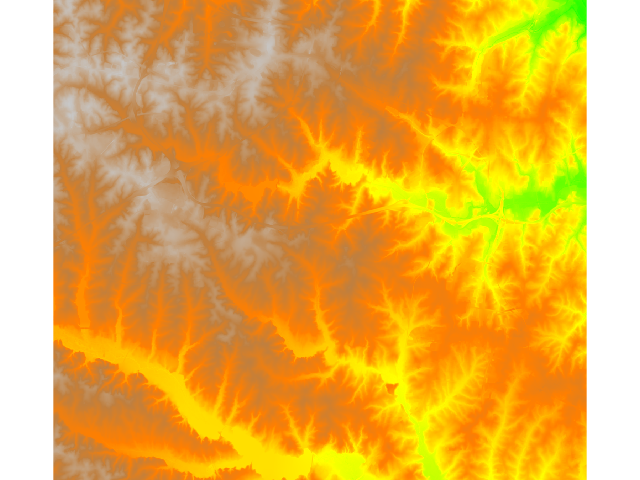

In [24]:
view(['doubled_elev'])

## 调用GRASS GIS的其他模块

使用以下方法从pygrass库中导入Module类：

In [26]:
from grass.pygrass.modules import Module

使用以下命令执行GRASS GIS模块：（例如可视范围计算）：

In [27]:
viewshed = Module('r.viewshed', input='elevation', output='viewshed2', coordinates=(635818.8, 221342.4), flags='c')

我们可以基于python实例，获取输入和输出参数和标志的信息：

In [29]:
viewshed.inputs.input

'elevation'

In [30]:
viewshed.inputs.coordinates

[(635818.8, 221342.4)]

In [31]:
viewshed.outputs.output

'viewshed2'

In [32]:
viewshed.flags.c

True

同样，可以对参数的值进行修改：

In [33]:
viewshed.inputs.coordinates = [(635825, 221350)]

或重新执行仅传递需要不同参数的模块：

In [34]:
viewshed(output='viewshed_newpoint')

Module('r.viewshed')

可以检索将以bash和Python风格执行的命令字符串形式：

In [35]:
viewshed.get_bash()

u'r.viewshed input=elevation coordinates=635825,221350 observer_elevation=1.75 target_elevation=0.0 max_distance=-1.0 refraction_coeff=0.14286 memory=500 output=viewshed_newpoint -c'

In [36]:
viewshed.get_python()

u"r.viewshed(input='elevation', output='viewshed_newpoint', coordinates=[(635825, 221350)], observer_elevation=1.75, target_elevation=0.0, max_distance=-1.0, refraction_coeff=0.14286, memory=500, flags=u'c')"

### Module类的其他参数

#### run\_

参数` run_`定义模块是否必须执行，默认值为True。

#### finish\_

The `finish_` 参数定义模块是否必须等待过程结束，默认为True

#### env\_

The `env_` 参数定义了将由进程设置和使用的环境变量。

#### stdin\_, stdout\_, stderr\_

参数 `stdin_`, `stdout_` and `stderr_` 用于传递或捕获GRASS GIS模块的输入或输出。

#### 示例

In [38]:
import subprocess as sub

# 使用Module类对象的另一种方法是通过快捷方式
# 导入常规模块的快捷方式
from grass.pygrass.modules.shortcuts import general as g

现在，可以调用并捕获GRASS GIS模块的标准输出，方法如下：

In [39]:
greg = g.region(flags='p', stdout_=sub.PIPE)
print(greg.outputs.stdout)

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      10
ewres:      10
rows:       1350
cols:       1500
cells:      2025000

